In [2]:
import json
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler

## Read in Comments Data

In [3]:
with open(r'../Data/Dataset/comments.json') as f:
    comments = json.load(f)

In [4]:
df = pd.DataFrame(comments)[['comment', 'label']]
df = df[(df['label'] == 1) | (df['label'] == 2)]
df.head()

,comment,label
5,Lol,2
18,With Rosen still on the board I gotta think th...,2
21,mistake,2
22,I think its a great pick at 7,1
23,I am; mistake lol,2


## Consolidate Negative Comments

In [14]:
def clean_text(text):
    cleaned = str.lower(text)
    cleaned = re.sub(r'lo[o]*l[l]*([o]+|[l]+)+', 'lol', cleaned)
    cleaned = re.sub(r'lo[o]+l', 'lol', cleaned)
    cleaned = re.sub(r'lol[a-z]+', 'lol', cleaned)
    cleaned = re.sub(r'l[e]+[l]', 'lol', cleaned)
    cleaned = re.sub(r'rofl[rofl]+', 'rofl', cleaned)
    
    cleaned = re.sub(r'lm[m]*[f]*a[a]*[o]+', 'lmao', cleaned)
    
    cleaned = re.sub(r'[b]*[w]*[a]*haha([a]+|[h]+)+', 'haha', cleaned)
    
    cleaned = re.sub(r'w(u|a)[t]+', 'what', cleaned)
    cleaned = re.sub(r'wh[h]*a[a]*t[t]*', 'what', cleaned)
    
    cleaned = re.sub('ew[w]+', 'ew', cleaned)
    cleaned = re.sub('ugh[h]+', 'ugh', cleaned)
    
    cleaned = re.sub('boo[o]+', 'boo', cleaned)
    
    cleaned = re.sub('f[f]*u[u]*c[c]*k[k]*', 'fuck', cleaned)
    
    cleaned = re.sub('oh[h]+', 'oh', cleaned)
    cleaned = re.sub('uh[h]+', 'uh', cleaned)
    cleaned = re.sub('a[a]*h[h]*', 'ah', cleaned)
    
    cleaned = re.sub('wt[t]*f[f]*', 'wtf', cleaned)
    
    cleaned = re.sub('wo[o]*w[w]*', 'wow', cleaned)
    
    cleaned = re.sub('no[o]+', 'no', cleaned)
    cleaned = re.sub('no[no]+', 'no', cleaned)
    
    cleaned = re.sub('oo[o]*ps[s]*', 'oops', cleaned)
    
    cleaned = re.sub('bu[u]*s[s]*t[t]*', 'bust', cleaned)
    
    return cleaned

In [17]:
cleaned_comments = [clean_text(comment) for comment in list(df['comment'])]
df['comment'] = cleaned_comments

## Dataset Overview

In [18]:
comments = df.to_numpy()

To get all comment text:

In [19]:
comments[:, 0]

array(['lol',
       'with rosen still on the board i gotta think this is a mistake',
       'mistake', ...,
       "williams helped his stats so much. not a fan at all. he's clutch and good in the pocket but that championship game made him a value he never deserved imho.",
       'rip whatson ', 'sorry jj what, no playoffs for you.'],
      dtype=object)

To get all labels:

In [20]:
comments[:, 1]

array([2, 2, 2, ..., 2, 2, 2], dtype=object)

Total dataset size:

In [21]:
len(comments)

4268

## Consolidating Negative Comments

## Create Model Objects

In [22]:
docs = list(comments[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [23]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=30, min_count=2, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [24]:
doc_vectors = []
for i in range(0, len(tagged_data)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

## Visualize

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2)
pca.fit(doc_scaled)

plot_points = pca.transform(doc_scaled)

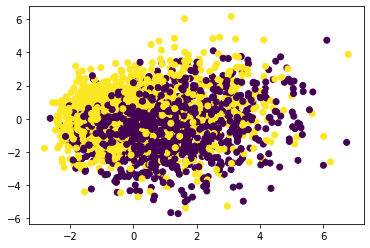

In [27]:
plt.scatter(plot_points[:, 0], plot_points[:, 1], c = comments[:, 1])

## Classify

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

**Balance Labels**

In [30]:
df = pd.DataFrame(doc_scaled)
df['label'] = np.array(comments[:, 1], dtype=int)

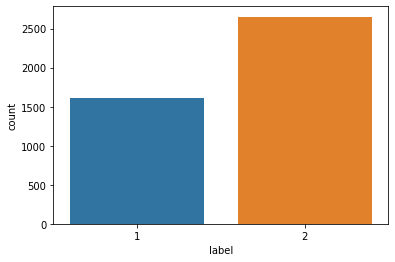

In [31]:
sns.countplot(df['label'])

In [32]:
df['label'].value_counts()

2    2652
1    1616
Name: label, dtype: int64

In [33]:
sampled_df = pd.concat([df[df['label'] == 2].sample(n=1616), df[df['label'] == 1]])

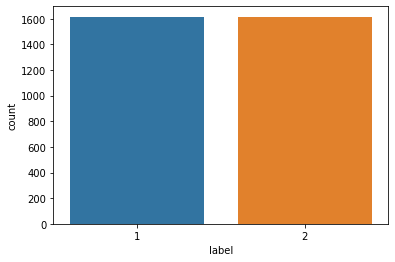

In [34]:
sns.countplot(sampled_df['label'])

In [35]:
sampled_df['label'].value_counts()

1    1616
2    1616
Name: label, dtype: int64

In [36]:
X = sampled_df.drop('label', axis=1)
y = sampled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

**Logistic Regression**

In [37]:
log = LogisticRegression()
log.fit(X_train, y_train)
pred = log.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[234  87]
 [ 70 256]]
0.7573415765069552


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**Naive Bayes**

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[199 122]
 [102 224]]
0.6537867078825348


**Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[279  42]
 [116 210]]
0.7557959814528593


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Support Vector Machine**

In [42]:
from sklearn.svm import SVC

In [43]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[275  46]
 [ 69 257]]
0.8222565687789799


Let's do a grid search for optimal parameters on our SVC:

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
param_grid = {'C': [1, 10, 100, 1000, 10000, 100000],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
              'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.773, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.758, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.780, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.694, total=   0.3s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.666, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.692, total=   0.4s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV] .... C=1, gamma=0.0005, kernel=linear, score=0.773, total=   0.5s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV] .... C=1, gamma=0.0005, kernel=linear, score=0.758, total=   0.4s
[CV] C=1, gamma=0.0005, kernel=linear ................................
[CV] .... C=1, gamma=0.0005, kernel=linear, score=0.780, total=   0.5s
[CV] C=1, gamma=0.0005, kernel=rbf ...................................
[CV] .

[CV] .... C=10, gamma=0.005, kernel=linear, score=0.774, total=   2.9s
[CV] C=10, gamma=0.005, kernel=linear ................................
[CV] .... C=10, gamma=0.005, kernel=linear, score=0.755, total=   3.1s
[CV] C=10, gamma=0.005, kernel=linear ................................
[CV] .... C=10, gamma=0.005, kernel=linear, score=0.780, total=   3.0s
[CV] C=10, gamma=0.005, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.005, kernel=rbf, score=0.795, total=   0.3s
[CV] C=10, gamma=0.005, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.005, kernel=rbf, score=0.806, total=   0.3s
[CV] C=10, gamma=0.005, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.005, kernel=rbf, score=0.791, total=   0.3s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.774, total=   2.9s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] .

KeyboardInterrupt: 